# Dataset Generation Tools

In this notebook, we generate signals used for our wireless adversarial machine learning tasks.

In [51]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

sns.set() # Use seaborn themes.

## Complex Time Series

TensorFlow does not currently accept complex numbers in loss functions. The reason is because complex numbers are not ordered, but real numbers are (see [StackOverflow](https://stackoverflow.com/a/58876622)).

One solution is to convert the I/Q data into magnitude and phase components, which can then be used as input features to the model.

In [52]:
def n2t(
    n: int|tuple[int,int]|np.ndarray[int],
    fs: float,
    ) -> np.ndarray[float]:
    """Convert discrete sample vector to time.

    Args:
        n (int | tuple[int,int] | np.ndarray[int]): Number of samples to simulate, or 2-tuple of discrete sample ranges, or vector of discrete samples.
        fs (float): Sample rate (Hz).

    Returns:
        np.ndarray[float]: Vector of time values (units of seconds).
    """
    if isinstance(n, int): # Discrete sample vector starting from zero.
        n = np.r_[0:n]
    elif isinstance(n, (list,tuple)): # 2-tuple of discrete range indices.
        assert len(n) == 2,'vector slice must be a 2-tuple'
        n = np.r_[n[0]:n[1]]
    return n.astype(float)/fs # Time vector.

def t2n(
    t: float|tuple[float,float]|np.ndarray[float],
    fs: float,
    ) -> np.ndarray[int]:
    """Convert time sample vector to discrete.

    Args:
        t (float | tuple[float,float] | np.ndarray[float]): Length of time vector (starting from zero), or 2-tuple of time ranges, or vector of time samples.
        fs (float): Sample rate (Hz).

    Returns:
        np.ndarray[int]: Vector of discrete sample values.
    """
    if isinstance(t, float): # Discrete sample vector starting from zero.
        t = np.r_[0.:t]
    elif isinstance(t, (list,tuple)): # 2-tuple of discrete range indices.
        assert len(t) == 2,'vector slice must be a 2-tuple'
        t = np.r_[t[0]:t[1]]
    return (t*fs).astype(int)

In [53]:
def wave(
    fc: float|np.ndarray[float] = 0.,
    t: np.ndarray[float] = 0.,
    phi: float|np.ndarray[float] = 0.,
    ) -> np.ndarray[np.complex64]:
    """Sinusoid waveform generator from time vector.

    Args:
        fc (float|np.ndarray[float], optional): Carrier frequency (Hz). Defaults to zero.
        t (np.ndarray[float], optional): Vector of time values (seconds). Defaults to zero.
        phi (float|np.ndarray[float], optional): Signal phase, or vector of phases. Defaults to zero.

    Returns:
        np.ndarray[np.complex64]: Complex sinusoid values.
    """
    if phi is None: # Catch phase being set null.
        phi = 0.
    if fc is None: # Catch carrier frequency being set to null.
        fc = 0.
    if t is None: # Catch time vector being set to null.
        t = 0.
    k = 2.*np.pi*fc*t + phi # Content of Euler's formula.
    x = np.exp(1.j*k) # Complex sinusoid.
    return x

## Modulation Schemes

Here we define several modulation schemes that are used to generate our dataset. The PySDR "Digital Modulation" guides have a wonderful tutorial on this ([source](https://pysdr.org/content/digital_modulation.html)).

In [54]:
def psk(
    scheme: np.ndarray[float],
    bits: np.ndarray[int], # Bits to encode.
    baud: int, # Symbol rate (bits/second).
    fs: float,
    fc: float = None,
    ) -> np.ndarray[float]:
    """Phase shift keying (PSK) modulation.

    Args:
        scheme (np.ndarray[float]): Bit-to-symbol lookup array.
        bits (np.ndarray[int]): Array of bits to modulate.
        fc (float, optional): Carrier frequency. Defaults to None.

    Returns:
        np.ndarray[float]: Modulated signal.
    """
    n_bits = len(bits) # Number of bits to encode.
    n_samples_per_bit = int(fs/baud) # Number of samples per bit.
    n_samples = n_bits*n_samples_per_bit # Total number of samples for the number of bits we have.

    # Lookup phases for each bit in the sequence.
    phi = np.repeat(scheme[bits], n_samples_per_bit) # Phase lookup.

    # Generate time vector.
    if fc is None:
        t = None
    else:
        t = n2t(n=n_samples, fs=fs)

    # Generate signal.
    x = wave(fc=fc, t=t, phi=phi)
    return x

def bpsk(*args, **kwargs):

    ###
    # BPSK Modulation
    #
    # Symbol    Phase
    # 0         0
    # 1         pi
    ###
    scheme = np.array([0, np.pi])
    return psk(scheme, *args, **kwargs)

def qpsk(*args, **kwargs):

    ###
    # QPSK Modulation
    #
    # Symbol    Phase
    # 00         pi/4
    # 01         7pi/4
    # 10         3pi/4
    # 11         5pi/4
    ###
    scheme = np.array([np.pi/4, 7*np.pi/4, 3*np.pi/4, 5*np.pi/4])
    return psk(scheme, *args, **kwargs)

## Examples

### Simple Waveform

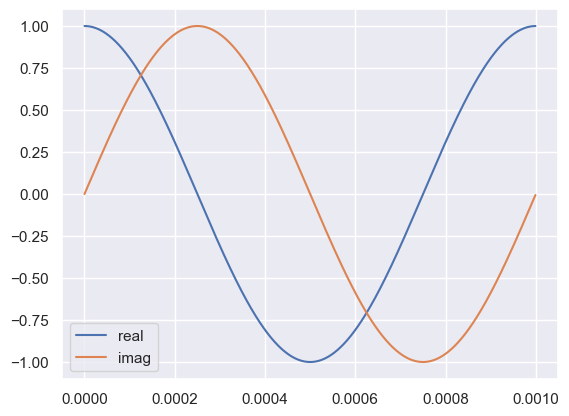

In [55]:
fc = 1e3
fs = 10e5
n_samples = 1000
t = n2t(n=n_samples, fs=fs)
phi = None
x = wave(fc=fc, t=t, phi=phi)

plt.plot(t, np.real(x), label='real')
plt.plot(t, np.imag(x), label='imag')
plt.legend()

### BPSK

<Figure size 640x480 with 0 Axes>

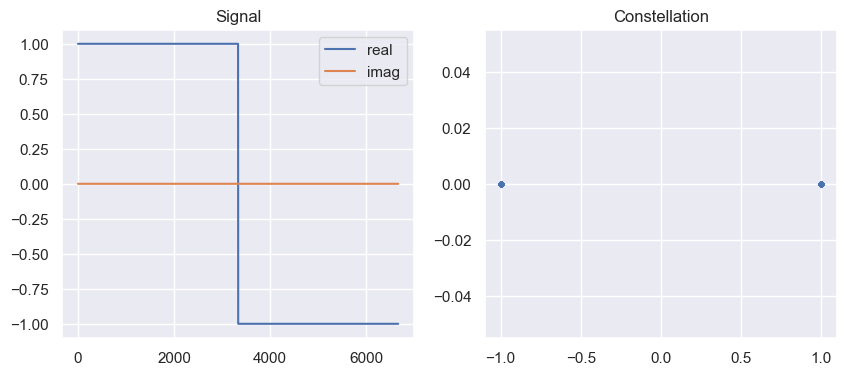

In [76]:
fc = None # 1e3
fs = 10e5
bits = np.arange(0, 2)
baud = 300
x = bpsk(bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]


plt.figure()

fig, axd = plt.subplot_mosaic("AB", figsize=(10,4))
axd['A'].plot(n, np.real(x), label='real')
axd['A'].plot(n, np.imag(x), label='imag')
axd['A'].set_title('Signal')
axd['A'].legend()

axd['B'].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
axd['B'].set_title('Constellation')
axd['B'].grid(True)

### QPSK

<Figure size 640x480 with 0 Axes>

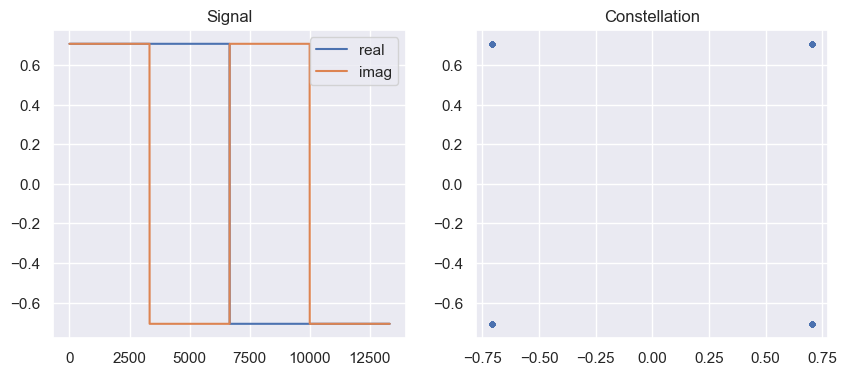

In [77]:
fc = None # 1e3
fs = 10e5
bits = np.arange(0, 4)
baud = 300
x = qpsk(bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]


plt.figure()

fig, axd = plt.subplot_mosaic("AB", figsize=(10,4))
axd['A'].plot(n, np.real(x), label='real')
axd['A'].plot(n, np.imag(x), label='imag')
axd['A'].set_title('Signal')
axd['A'].legend()

axd['B'].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
axd['B'].set_title('Constellation')
axd['B'].grid(True)